# Tutorial for the structural-color python package

Copyright 2016, Vinothan N. Manoharan, Victoria Hwang. 

This file is part of the structural-color python package.

This package is free software: you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation, either version 3 of the License, or (at your option) any later
version.

This package is distributed in the hope that it will be useful, but WITHOUT
ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
FOR A PARTICULAR PURPOSE. See the GNU General Public License for more
details.

You should have received a copy of the GNU General Public License along with
this package. If not, see <http://www.gnu.org/licenses/>.

## Loading and using the package

To load, make sure you are in the top directory and do

In [1]:
import structcol
# or 
import structcol as sc

This will populate the structcol namespace with a few functions and classes.  You will probably find it easiest to keep all your calculations within a Jupyter notebook like this one.  The package itself contains only generic functions and classes (that is, it doesn't include any specific calculations of structural color spectra beyond the ones in this notebook).  For calculations in a notebook, you'll want to import some other packages too, like numpy and matplotlib:

In [2]:
%matplotlib inline 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

# require seaborn (not installed by default in Anaconda; comment out if not installed)
import seaborn as sns

## Using quantities with units

The structural-color package uses the [`pint`](http://pint.readthedocs.io/en/latest/) package to keep track of units and automatically convert them.  To define a quantity with units, use the `structcol.Quantity` constructor.  For example, to define a wavelength of 0.45 $\mu$m:

In [3]:
wavelen = sc.Quantity('0.45 um')

In [4]:
print(wavelen)
print(wavelen.dimensionality)

0.45 micrometer
[length]


Converting between units:

In [5]:
print(wavelen.to('m'))

4.5e-07 meter


Units work in numpy arrays, too:

In [6]:
wavelens = sc.Quantity(np.arange(450.0, 800.0, 10.0), 'nm')

In [7]:
print(wavelens.to('um'))

[0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79] micrometer


## Refractive index module

To use the refractive index module:

In [8]:
import structcol.refractive_index as ri

This module contains dispersion relations for a number of materials.  For example, to get the index of polystyrene at 500 nm, you can call

In [9]:
ri.n('polystyrene', sc.Quantity('500 nm'))

<Quantity(1.6032768445664916, 'dimensionless')>

You must give this function a quantity with units as the second argument.  If you give it a number, it will throw an error, rather than trying to guess what units you're thinking of.  You can also calculate the refractive index at several different wavelengths simultaneously, like this (using `wavelens` array from above):

In [10]:
n_particle = ri.n('polystyrene', wavelens)

Text(0.5,0,'wavelength (nm)')

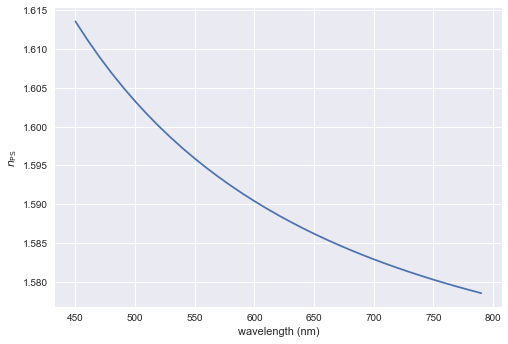

In [11]:
plt.plot(wavelens, n_particle)
plt.ylabel('$n_\mathrm{PS}$')
plt.xlabel('wavelength (nm)')

You can use complex refractive indices by adding the imaginary component of the index. Note that in python the imaginary number $i$ is denoted by $j$. You can choose to use the values from literature or from experimental measurement:

In [12]:
ri.n('polystyrene', sc.Quantity('500 nm'))+0.0001j

<Quantity((1.6032768445664916+0.0001j), 'dimensionless')>

#### Importing your own refractive index data

You can input your own refractive index data (which can be real or complex) by calling the material $\textbf{'data'}$ and specifying the optional parameter $\textbf{'index'}$:

In [13]:
wavelength = sc.Quantity(np.array([400,500,600]), 'nm')
data = np.array([1.5,1.55,1.6])
n_data = ri.n('data', wavelength, index=data)

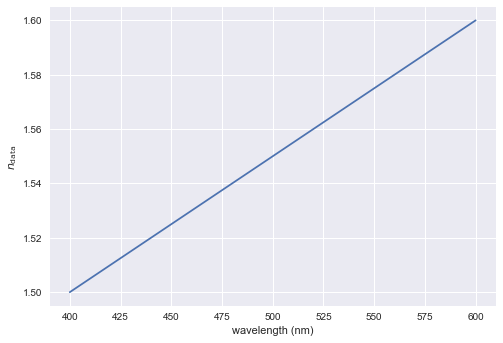

In [14]:
plt.plot(wavelength, n_data)
plt.ylabel('$n_\mathrm{data}$')
plt.xlabel('wavelength (nm)');

## Calculating a reflection spectrum
With the tools above we can calculate a reflection spectrum using the single-scattering model described in Magkiriadou, S., Park, J.-G., Kim, Y.-S., and Manoharan, V. N. “Absence of Red Structural Color in Photonic Glasses, Bird Feathers, and Certain Beetles” Physical Review E 90, no. 6 (2014): 62302. doi:10.1103/PhysRevE.90.062302

The effective refractive index of the sample can be calculated either with the Maxwell-Garnett formulation or the Bruggeman equation. The Bruggeman equation is the default option for our calculations, because Maxwell-Garnett is not valid when the volume fractions of the components are comparable, which is often the case in structural color samples (Markel, V. A., "Introduction to the Maxwell Garnett approximation: tutorial", Journal of the Optical Socienty of America A, 33, no. 7 (2016)). In addition, Maxwell Garnett only works for systems of two components (e.g. a particle index and a matrix index), whereas Bruggeman can be applied to multicomponent systems such as core-shell particles. 

The model can also handle absorbing systems, either with an absorbing particle or an absorbing matrix. Then the  corresponding complex refractive indices must be specified. 

In [15]:
# uncomment the line below to time how long this calculation takes
# %%timeit 
from structcol import model

# parameters for our colloidal sample
volume_fraction = sc.Quantity(0.64, '')
radius = sc.Quantity('125 nm')

# wavelengths of interest
wavelength = sc.Quantity(np.arange(400., 800., 10.0), 'nm')

# calculate refractive indices at wavelengths of interest
n_particle = sc.Quantity(1.53, '')#ri.n('polystyrene', wavelength)
n_matrix = ri.n('vacuum', wavelength)
n_medium = n_matrix

# now calculate the reflection spectrum, asymmetry parameter (g), and 
# transport length (lstar)
refl = np.zeros(wavelength.size)
g = np.zeros(wavelength.size)
# note the units explicitly assigned to the transport length; you
# must specify a length unit here
lstar = np.zeros(wavelength.size)*sc.ureg('um')
for i in range(wavelength.size):
    # the first element in the tuple is the reflection coefficient for 
    # unpolarized light.  The next two (which we skip) are the 
    # coefficients for parallel and perpendicularly polarized light.
    # Third is the asymmetry parameter, and fourth the transport length
    refl[i], _, _, g[i], lstar[i] = model.reflection(n_particle, n_matrix[i],
                                                     n_medium[i], wavelength[i],
                                                     radius, volume_fraction, 
                                                     thickness = sc.Quantity('4000.0 nm'),
                                                     theta_min = sc.Quantity('90 deg'), 
                                                     maxwell_garnett=False) # the default option is False

/Users/vhwang/anaconda/lib/python3.5/site-packages/pint/quantity.py:715: RuntimeWarning: divide by zero encountered in long_scalars
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


Text(0.5,0,'wavelength (nm)')

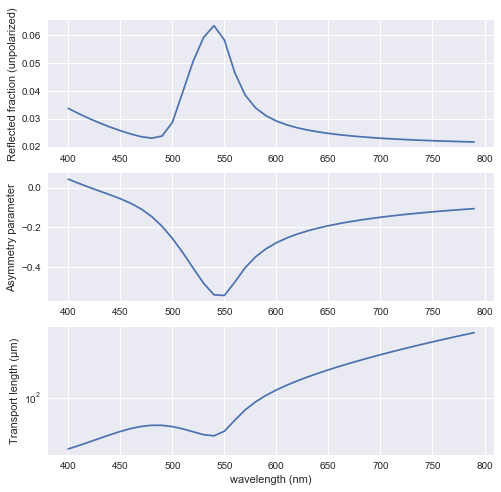

In [16]:
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=3, figsize=(8,8))
ax_a.plot(wavelength, refl)
ax_a.set_ylabel('Reflected fraction (unpolarized)')

ax_b.plot(wavelength, g)
ax_b.set_ylabel('Asymmetry parameter')

ax_c.semilogy(wavelength, lstar)
ax_c.set_ylabel('Transport length (μm)')
ax_c.set_xlabel('wavelength (nm)')

Note that the asymmetry parameter becomes negative at the reflection peak (as expected, since light is preferentially backscattered), and, as a result, the transport length has a dip in the same wavelength region.

### Calculating the reflection spectrum of a core-shell particle system, with either an absorbing or non-absorbing particle index

We can calculate a reflection spectrum of a system of core-shell particles, where the core and the shell(s) can have different radii and refractive indices. The syntax is mostly the same as that of non-core-shell particles, except that the particle radius and the particle index are now Quantity arrays of values from the innermost (the core) to the outermost layer in the particle. The volume fraction is that of the entire core-shell particle. 

In [17]:
# Example calculation for a core-shell particle system (core is polystyrene and shell is silica, in a matrix of air) 
from structcol import model

# parameters for our colloidal sample
volume_fraction = sc.Quantity(0.5, '')
radius = sc.Quantity(np.array([110,120]), 'nm')

# wavelengths of interest
wavelength = sc.Quantity(np.arange(400., 800., 10.0), 'nm')

# calculate refractive indices at wavelengths of interest
n_particle = sc.Quantity([ri.n('polystyrene', wavelength), ri.n('fused silica', wavelength)])
n_particle_abs = sc.Quantity([ri.n('polystyrene', wavelength), 
                              ri.n('fused silica', wavelength)+0.005j]) # assume the shell absorbs
n_matrix = ri.n('vacuum', wavelength)                                                           
n_medium = n_matrix

# now calculate the reflection spectrum, asymmetry parameter (g), and 
# transport length (lstar)
refl = np.zeros(wavelength.size)
g = np.zeros(wavelength.size)
lstar = np.zeros(wavelength.size)*sc.ureg('um')
refl_abs = np.zeros(wavelength.size)
g_abs = np.zeros(wavelength.size)
lstar_abs = np.zeros(wavelength.size)*sc.ureg('um')

for i in range(wavelength.size):
    # non-absorbing case
    refl[i], _, _, g[i], lstar[i] = model.reflection(n_particle[:,i], n_matrix[i],
                                                     n_medium[i], wavelength[i],
                                                     radius, volume_fraction, 
                                                     thickness = sc.Quantity('15000.0 nm'),
                                                     theta_min = sc.Quantity('90 deg'))
    # absorbing case
    refl_abs[i], _, _, g_abs[i], lstar_abs[i] = model.reflection(n_particle_abs[:,i], n_matrix[i],
                                                                 n_medium[i], wavelength[i],
                                                                 radius, volume_fraction, 
                                                                 thickness = sc.Quantity('15000.0 nm'),
                                                                 theta_min = sc.Quantity('90 deg'))

/Users/vhwang/anaconda/lib/python3.5/site-packages/pint/quantity.py:715: RuntimeWarning: divide by zero encountered in long_scalars
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


Text(0.5,0,'wavelength (nm)')

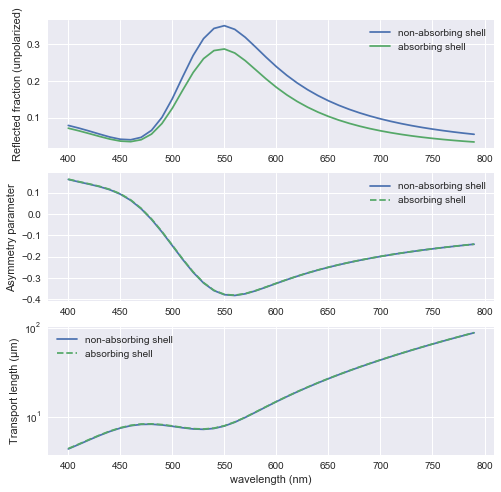

In [18]:
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=3, figsize=(8,8))
ax_a.plot(wavelength, refl, label='non-absorbing shell')
ax_a.plot(wavelength, refl_abs, label='absorbing shell')
ax_a.legend()
ax_a.set_ylabel('Reflected fraction (unpolarized)')

ax_b.plot(wavelength, g, label='non-absorbing shell')
ax_b.plot(wavelength, g_abs, '--', label='absorbing shell')
ax_b.legend()
ax_b.set_ylabel('Asymmetry parameter')

ax_c.semilogy(wavelength, lstar, label='non-absorbing shell')
ax_c.semilogy(wavelength, lstar_abs, '--', label='absorbing shell')
ax_c.legend()
ax_c.set_ylabel('Transport length (μm)')
ax_c.set_xlabel('wavelength (nm)')

### Calculating the reflection spectrum of a polydisperse system with either one species or two species of particles

We can calculate the spectrum of a polydisperse system with either one or two species of particles, meaning that there are one or two mean radii, and each species has its own size distribution. We then need to specify the mean radius, the polydispersity index (pdi), and the concentration of each species. For example, consider a system of 90$\%$ of 200 nm polystyrene particles and 10$\%$ of 300 nm particles, with each species having a polydispersity index of 1$\%$. In this case, the mean radii are [200, 300] nm, the pdi are [0.01, 0.01], and the concentrations are [0.9, 0.1]. 

If the system is monospecies, we still need to specify the polydispersity parameters in 2-element arrays. For example, the mean radii become [200, 200] nm, the pdi become [0.01, 0.01], and the concentrations become [1.0, 0.0]. 

To include absorption into the polydisperse system calculation, we just need to use the complex refractive index of the particle and/or the matrix. 

Note: the code takes longer (~1 min) in the polydisperse than in the monodisperse case because it calculates the scattering for a distribution of particles. 

Note 2: the code currently does not handle polydispersity for systems of core-shell particles. 

In [19]:
# Example calculation for a polydisperse system with two species of particles, each with its own size distribution
from structcol import model

# parameters for our colloidal sample
volume_fraction = sc.Quantity(0.5, '')
radius = sc.Quantity('100 nm')

# define the parameters for polydispersity
radius2 = sc.Quantity('150 nm')
concentration = sc.Quantity(np.array([0.9,0.1]), '')
pdi = sc.Quantity(np.array([0.01, 0.01]), '')

# wavelengths of interest
wavelength = sc.Quantity(np.arange(400., 800., 10.0), 'nm')

# calculate refractive indices at wavelengths of interest
n_particle = ri.n('polystyrene', wavelength)
n_matrix = ri.n('vacuum', wavelength)                                                           
n_medium = n_matrix

# now calculate the reflection spectrum, asymmetry parameter (g), and 
# transport length (lstar)
refl_mono = np.zeros(wavelength.size)
g_mono = np.zeros(wavelength.size)
lstar_mono = np.zeros(wavelength.size)*sc.ureg('um')
refl_poly = np.zeros(wavelength.size)
g_poly = np.zeros(wavelength.size)
lstar_poly = np.zeros(wavelength.size)*sc.ureg('um')

for i in range(wavelength.size):
    # need to specify extra parameters for the polydisperse (and bispecies) case
    refl_poly[i], _, _, g_poly[i], lstar_poly[i] = model.reflection(n_particle[i], n_matrix[i],
                                                                    n_medium[i], wavelength[i],
                                                                    radius, volume_fraction, 
                                                                    thickness = sc.Quantity('15000.0 nm'),
                                                                    theta_min = sc.Quantity('90 deg'), 
                                                                    radius2 = radius2, concentration = concentration, 
                                                                    pdi = pdi, structure_type='polydisperse',
                                                                    form_type='polydisperse')
    # monodisperse (assuming the system is composed of purely the 200 nm particles)
    refl_mono[i], _, _, g_mono[i], lstar_mono[i] = model.reflection(n_particle[i], n_matrix[i],
                                                                    n_medium[i], wavelength[i],
                                                                    radius, volume_fraction, 
                                                                    thickness = sc.Quantity('15000.0 nm'),
                                                                    theta_min = sc.Quantity('90 deg'))

/Users/vhwang/anaconda/lib/python3.5/site-packages/pint/quantity.py:715: RuntimeWarning: divide by zero encountered in long_scalars
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


Text(0.5,0,'wavelength (nm)')

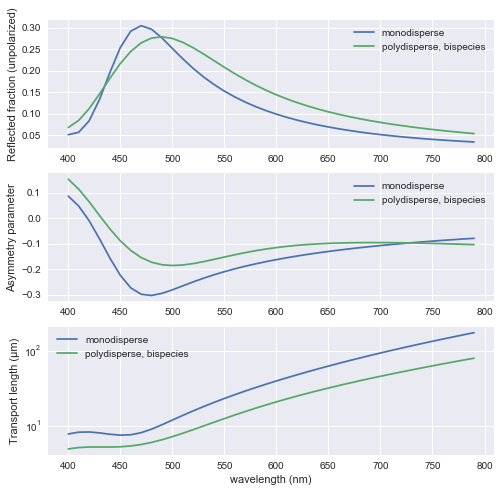

In [20]:
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=3, figsize=(8,8))
ax_a.plot(wavelength, refl_mono, label='monodisperse')
ax_a.plot(wavelength, refl_poly, label='polydisperse, bispecies')
ax_a.legend()
ax_a.set_ylabel('Reflected fraction (unpolarized)')

ax_b.plot(wavelength, g_mono, label='monodisperse')
ax_b.plot(wavelength, g_poly, label='polydisperse, bispecies')
ax_b.legend()
ax_b.set_ylabel('Asymmetry parameter')

ax_c.semilogy(wavelength, lstar_mono, label='monodisperse')
ax_c.semilogy(wavelength, lstar_poly, label='polydisperse, bispecies')
ax_c.legend()
ax_c.set_ylabel('Transport length (μm)')
ax_c.set_xlabel('wavelength (nm)')

Note that the polydisperse case has a broader and red-shifted peak compared to the monodisperse case. This trend makes sense since the polydisperse system contains 10$\%$ of larger particles than the monodisperse system. 

## Mie scattering module

Normally you won't need to use this model on its own, but if you want to, start with

In [21]:
from structcol import mie

Form factor calculation:

In [22]:
wavelen = sc.Quantity('450 nm')
n_matrix = ri.n('vacuum', wavelen)
n_particle = ri.n('polystyrene', wavelen)
radius = sc.Quantity('0.4 um')
m = sc.index_ratio(n_particle, n_matrix)
x = sc.size_parameter(wavelen, n_matrix, radius)

# must explicitly state whether angles are in radians or degrees
angles = sc.Quantity(np.linspace(0, np.pi, 1000), 'rad')
form_factor_par, form_factor_perp = mie.calc_ang_dist(m, x, angles)

Text(0,0.5,'intensity')

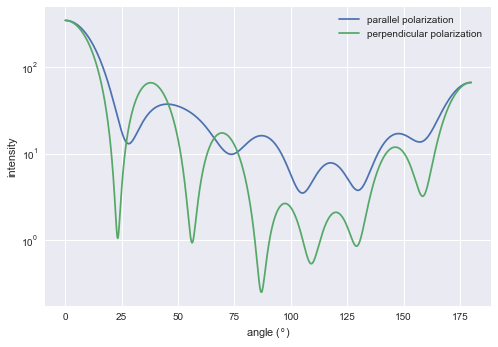

In [23]:
plt.semilogy(angles.to('deg'), form_factor_par, label='parallel polarization')
plt.plot(angles.to('deg'), form_factor_perp, label='perpendicular polarization')
plt.legend()
plt.xlabel('angle ($\degree$)')
plt.ylabel('intensity')

## Structure module

To use this module:

In [24]:
from structcol import structure

Here is an example of calculating structure factors with the Percus-Yevick approximation. The code is fully vectorized, so we can calculate structure factors for a variety of qd values and volume fractions in parallel:

In [25]:
qd = np.arange(0.1, 20, 0.01)
phi = np.array([0.15, 0.3, 0.45])
# this little trick allows us to calculate the structure factor on a 2d
# grid of points (turns qd into a column vector and phi into a row vector).
# Could also use np.ogrid
s = structure.factor_py(qd.reshape(-1,1), phi.reshape(1,-1))

Text(0,0.5,'$\\phi$')

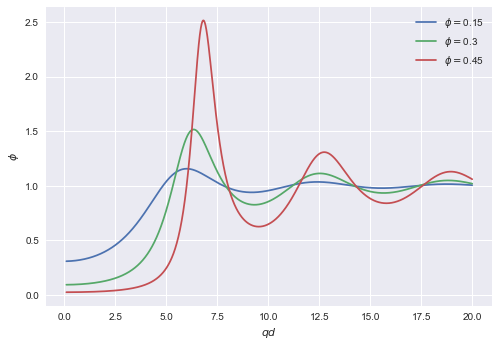

In [26]:
for i in range(len(phi)):
    plt.plot(qd, s[:,i], label='$\phi=$'+str(phi[i]))#, label='$phi='+phi[i]+'$')
plt.legend()
plt.xlabel('$qd$')
plt.ylabel('$\phi$')

## Development

Here are some tips for contributing code to the package:

1. Make sure that your code works in Python 3. You should write `print(x)` instead of `print x`, and you should check that any imported package is compatible with Python 3.

2. Wrap lines at 79 characters.  Use 4 spaces for each indent, and don't use tabs.

3. Write docstrings for all modules, functions, and classes.  We use the [numpy docstring standards](https://github.com/numpy/numpy/blob/master/doc/HOWTO_DOCUMENT.rst.txt#documenting-modules).

4. Write tests for any module you develop and for any changes or additions you make to existing modules.  We use the [nose testing framework](http://nose.readthedocs.io/en/latest/).  To run the tests, open a shell, go the to top-level directory (above the directory called "structcol"), and run `nosetests`.

5. Follow the [PEP 8 style guide](https://www.python.org/dev/peps/pep-0008/) for naming functions, classes, and modules.

6. If you contribute code to an existing file, add your name to the Copyright notice in the header.  Add another year if necessary (for example, if the notice says "Copyright 2015, A. Name" and the year is now 2016, amend the notice to read "Copyright 2015, 2016, A. Name and Your Name")

7. If you contribute a new file, add the [GPL copyright notice](https://www.gnu.org/licenses/gpl-howto.en.html) to the header (see other files in the package for examples) and put your name and the current year in the Copyright notice. 

8. Keep all proprietary information and non-open-source code out of the package, and make sure to cite sources for any calculation methods or dispersion formulas.